<a href="https://colab.research.google.com/github/2303a51851/PDS-Project/blob/main/All_Alg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Saving Crop_Yield_Prediction .csv to Crop_Yield_Prediction  (1).csv
‚úÖ Dataset Loaded Successfully!
   Year    State Name Dist Name  RICE YIELD (Kg per ha)  \
0  1966  Chhattisgarh      Durg                  337.59   
1  1967  Chhattisgarh      Durg                  747.71   
2  1968  Chhattisgarh      Durg                  841.27   
3  1969  Chhattisgarh      Durg                  711.40   
4  1970  Chhattisgarh      Durg                  828.55   

   KHARIF SORGHUM YIELD (Kg per ha)  PEARL MILLET YIELD (Kg per ha)  \
0                            666.67                             0.0   
1                            818.18                             0.0   
2                            800.00                             0.0   
3                            750.00                             0.0   
4                            666.67                             0.0   

   MAIZE YIELD (Kg per ha)  FINGER MILLET YIELD (Kg per ha)  \
0                   666.67                           2

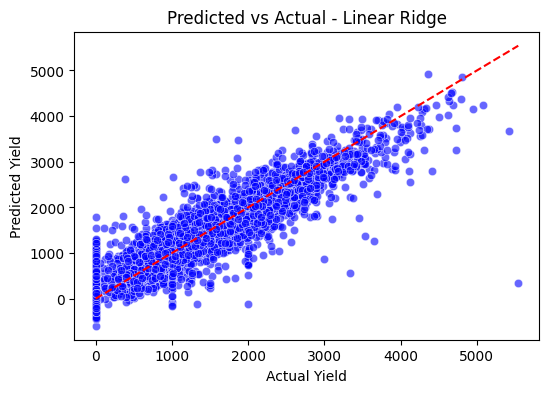

üöÄ Model: Lasso Regression
‚úÖ R¬≤ Score: 0.7938
‚úÖ MAE: 315.1448
‚úÖ RMSE: 433.7832


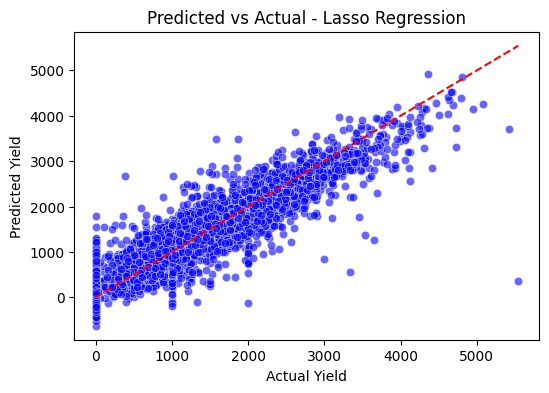

üöÄ Model: K-Nearest Neighbors
‚úÖ R¬≤ Score: 0.8237
‚úÖ MAE: 265.2162
‚úÖ RMSE: 401.1030


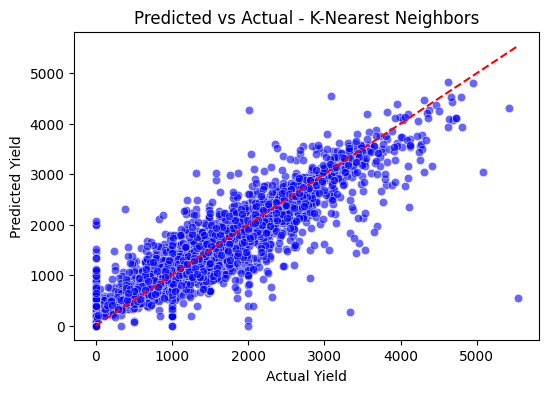

üöÄ Model: Decision Tree
‚úÖ R¬≤ Score: 0.7039
‚úÖ MAE: 350.5113
‚úÖ RMSE: 519.8336


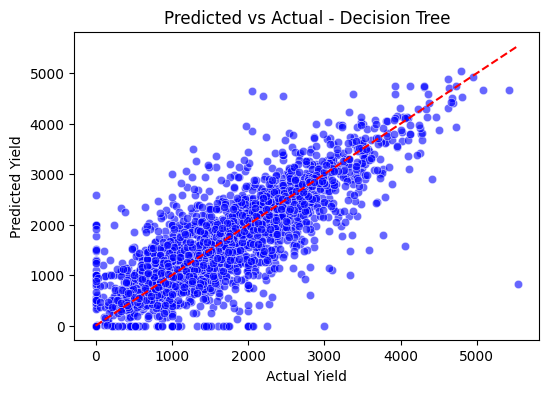

üöÄ Model: Random Forest
‚úÖ R¬≤ Score: 0.8531
‚úÖ MAE: 254.7471
‚úÖ RMSE: 366.1713


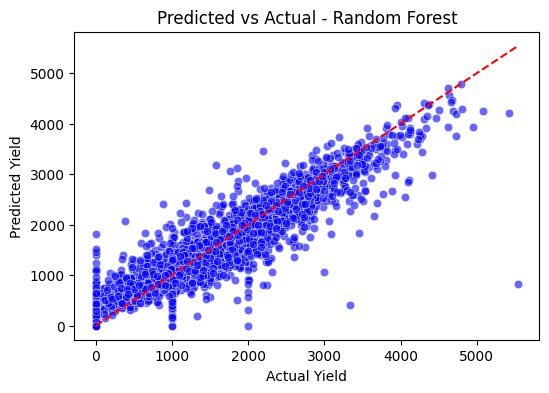

üöÄ Model: Gradient Boosting
‚úÖ R¬≤ Score: 0.7548
‚úÖ MAE: 352.3239
‚úÖ RMSE: 473.0736


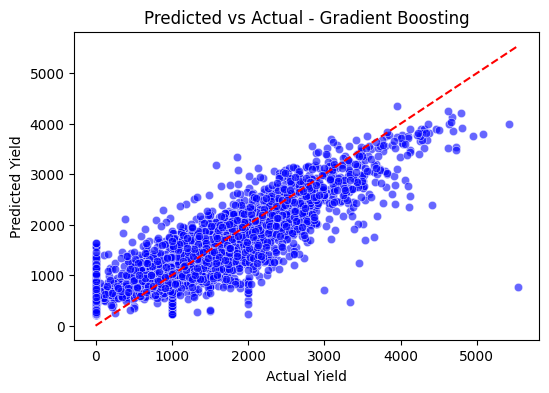

üöÄ Model: Extra Trees
‚úÖ R¬≤ Score: 0.8869
‚úÖ MAE: 213.0258
‚úÖ RMSE: 321.3052


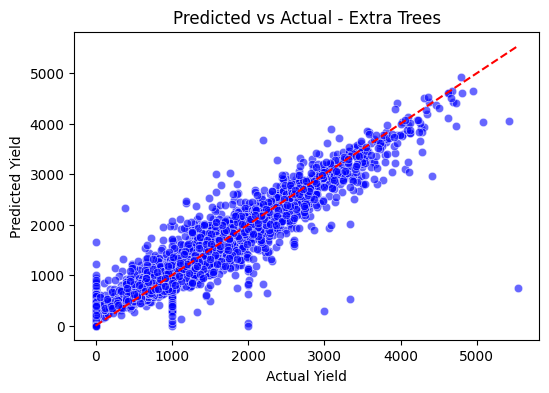

üöÄ Model: Neural Network (ANN)
‚ùå Error training Neural Network (ANN): 'dict' object has no attribute 'Sequential'
üöÄ Model: Voting Ensemble


In [ ]:
# =====================================================================
# üåæ Crop Yield Prediction using Rainfall, Temperature & Pesticides
# Ensemble + Deep Learning Model Comparison (Regression)
# =====================================================================

# ---------------------------------------------------------------------
# 1Ô∏è‚É£ Import Libraries
# ---------------------------------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# ML Models
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import (
    RandomForestRegressor, GradientBoostingRegressor,
    ExtraTreesRegressor, VotingRegressor, StackingRegressor
)
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.base import BaseEstimator, RegressorMixin

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from google.colab import files

# ---------------------------------------------------------------------
# 2Ô∏è‚É£ Load Dataset
# ---------------------------------------------------------------------
uploaded = files.upload()  # Upload your dataset (Crop_Yield_Prediction.csv)
df = pd.read_csv(next(iter(uploaded.keys())))
print("‚úÖ Dataset Loaded Successfully!")
print(df.head())

# ---------------------------------------------------------------------
# 3Ô∏è‚É£ Feature & Target Selection (Auto-Detection)
# ---------------------------------------------------------------------
possible_targets = [col for col in df.columns if "yield" in col.lower() or "production" in col.lower()]

if not possible_targets:
    raise KeyError("‚ùå Could not find any column containing 'Yield' or 'Production'. Please check your CSV.")
else:
    target_col = possible_targets[0]
    print(f"üéØ Auto-detected target column: '{target_col}'")

X = df.drop(columns=[target_col])
y = df[target_col]

# Drop obvious ID/date columns if they exist
drop_cols = [c for c in X.columns if "id" in c.lower() or "date" in c.lower()]
if drop_cols:
    X = X.drop(columns=drop_cols)
    print(f"‚öôÔ∏è Dropped non-feature columns: {drop_cols}")

# ---------------------------------------------------------------------
# 4Ô∏è‚É£ Train/Test Split
# ---------------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(f"Training Samples: {len(X_train)}, Testing Samples: {len(X_test)}")

# ---------------------------------------------------------------------
# 5Ô∏è‚É£ Preprocessing
# ---------------------------------------------------------------------
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(exclude=[np.number]).columns.tolist()

preprocess = ColumnTransformer(
    [
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ]
)

# ---------------------------------------------------------------------
# 6Ô∏è‚É£ Deep Learning Regressor Wrapper (Sklearn Compatible)
# ---------------------------------------------------------------------
class KerasRegressorCustom(BaseEstimator, RegressorMixin):
    _estimator_type = "regressor"

    def __init__(self, input_dim=None, lr=0.001, hidden=64, epochs=80, batch_size=32):
        self.input_dim = input_dim
        self.lr = lr
        self.hidden = hidden
        self.epochs = epochs
        self.batch_size = batch_size
        self.model_ = None

    def build_model(self):
        m = models.Sequential([
            layers.Input(shape=(self.input_dim,)),
            layers.Dense(self.hidden, activation='relu'),
            layers.Dropout(0.2),
            layers.Dense(self.hidden // 2, activation='relu'),
            layers.Dense(1)
        ])
        m.compile(optimizer=optimizers.Adam(learning_rate=self.lr), loss='mse')
        return m

    def fit(self, X, y):
        self.input_dim = X.shape[1]
        self.model_ = self.build_model()
        self.model_.fit(np.array(X), np.array(y),
                        epochs=self.epochs, batch_size=self.batch_size, verbose=0)
        return self

    def predict(self, X):
        return self.model_.predict(np.array(X)).flatten()

# ---------------------------------------------------------------------
# 7Ô∏è‚É£ Define Models (ML + DL + Ensembles)
# ---------------------------------------------------------------------
ann_model = KerasRegressorCustom()

models = {
    "Linear Ridge": Ridge(alpha=1.0),
    "Lasso Regression": Lasso(alpha=0.01),
    "K-Nearest Neighbors": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "Extra Trees": ExtraTreesRegressor(random_state=42),
    "Neural Network (ANN)": ann_model,
}

# ---------------------------------------------------------------------
# 8Ô∏è‚É£ Ensemble Techniques
# ---------------------------------------------------------------------
voting_ensemble = VotingRegressor([
    ("rf", models["Random Forest"]),
    ("gb", models["Gradient Boosting"]),
    ("et", models["Extra Trees"])
])

stacking_ensemble = StackingRegressor(
    estimators=[
        ("rf", models["Random Forest"]),
        ("gb", models["Gradient Boosting"]),
        ("et", models["Extra Trees"]),
    ],
    final_estimator=Ridge(alpha=1.0)
)

models["Voting Ensemble"] = voting_ensemble
models["Stacking Ensemble"] = stacking_ensemble

# ---------------------------------------------------------------------
# 9Ô∏è‚É£ Train, Evaluate, and Compare Models
# ---------------------------------------------------------------------
summary = []

for name, model in models.items():
    print("=" * 80)
    print(f"üöÄ Model: {name}")

    pipe = Pipeline([
        ("preprocess", preprocess),
        ("model", model)
    ])

    try:
        pipe.fit(X_train, y_train)
        preds = pipe.predict(X_test)

        r2 = r2_score(y_test, preds)
        mae = mean_absolute_error(y_test, preds)
        rmse = np.sqrt(mean_squared_error(y_test, preds))

        print(f"‚úÖ R¬≤ Score: {r2:.4f}")
        print(f"‚úÖ MAE: {mae:.4f}")
        print(f"‚úÖ RMSE: {rmse:.4f}")

        summary.append({"Model": name, "R2": r2, "MAE": mae, "RMSE": rmse})

        # Plot Predicted vs Actual
        plt.figure(figsize=(6, 4))
        sns.scatterplot(x=y_test, y=preds, color="blue", alpha=0.6)
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
        plt.xlabel("Actual Yield")
        plt.ylabel("Predicted Yield")
        plt.title(f"Predicted vs Actual - {name}")
        plt.show()

    except Exception as e:
        print(f"‚ùå Error training {name}: {e}")

# ---------------------------------------------------------------------
# üîü Summary Table
# ---------------------------------------------------------------------
summary_df = pd.DataFrame(summary).sort_values(by="R2", ascending=False)
print("\nüìä Model Performance Summary (sorted by R¬≤):\n")
print(summary_df.to_string(index=False))

# Barplot for comparison
plt.figure(figsize=(10,5))
sns.barplot(x="Model", y="R2", data=summary_df, palette="viridis")
plt.xticks(rotation=45, ha="right")
plt.title("Model Comparison - R¬≤ Score")
plt.show()

# ---------------------------------------------------------------------
# 1Ô∏è‚É£1Ô∏è‚É£ Save Best Model
# ---------------------------------------------------------------------
best_model_name = summary_df.iloc[0]["Model"]
print(f"üèÜ Best Performing Model: {best_model_name}")

best_pipe = Pipeline([
    ("preprocess", preprocess),
    ("model", models[best_model_name])
])
best_pipe.fit(X, y)
joblib.dump(best_pipe, "/content/best_crop_yield_model.pkl")
print("üíæ Best model saved as /content/best_crop_yield_model.pkl")

# ---------------------------------------------------------------------
# 1Ô∏è‚É£2Ô∏è‚É£ Batch Prediction from New CSV
# ---------------------------------------------------------------------
print("\nüìÅ Upload a new dataset for prediction (e.g., new_crop_data.csv):")
uploaded = files.upload()
new_file = next(iter(uploaded.keys()))
new_data = pd.read_csv(new_file)
print("‚úÖ New data loaded successfully!")
print(new_data.head())

# Predict with saved model
best_loaded = joblib.load("/content/best_crop_yield_model.pkl")
preds = best_loaded.predict(new_data)
new_data["Predicted_Yield"] = preds

# Save output
output_file = "predicted_crop_yield.csv"
new_data.to_csv(output_file, index=False)
print(f"üíæ Predictions saved to /content/{output_file}")

# Preview
print("\nüìä Predicted Results Sample:")
print(new_data.head())

# Download result file
files.download(output_file)


In [ ]:
# =====================================================================
# üåæ Crop Yield Prediction using Rainfall, Temperature, and Pesticides
# Supervised Machine Learning Regression Model Comparison
# =====================================================================

# ---------------------------------------------------------------------
# 1Ô∏è‚É£ Import Libraries
# ---------------------------------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# ---------------------------------------------------------------------
# 2Ô∏è‚É£ Load Dataset
# ---------------------------------------------------------------------
df = pd.read_csv("/content/Crop_Yield_Prediction .csv")  # Adjust path if needed
print("‚úÖ Dataset Loaded Successfully!")
print(df.head())

# ---------------------------------------------------------------------
# 3Ô∏è‚É£ Features and Target
# ---------------------------------------------------------------------
# Auto-detect the target column (e.g., Yield, crop_yield, production, etc.)
possible_targets = [col for col in df.columns if "yield" in col.lower() or "production" in col.lower()]
if not possible_targets:
    raise KeyError("‚ùå Could not find any column containing 'Yield' or 'Production'. Please check your dataset.")
else:
    target_col = possible_targets[0]
    print(f"üéØ Auto-detected target column: '{target_col}'")

X = df.drop(columns=[target_col])
y = df[target_col]

# ---------------------------------------------------------------------
# 4Ô∏è‚É£ Train/Test Split
# ---------------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(f"Training Samples: {len(X_train)}, Testing Samples: {len(X_test)}")

# ---------------------------------------------------------------------
# 5Ô∏è‚É£ Preprocessing
# ---------------------------------------------------------------------
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(exclude=[np.number]).columns.tolist()

preprocess = ColumnTransformer(
    [
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ]
)

# ---------------------------------------------------------------------
# 6Ô∏è‚É£ Regression Models
# ---------------------------------------------------------------------
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Lasso Regression": Lasso(alpha=0.001),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Extra Trees": ExtraTreesRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "K-Nearest Neighbors": KNeighborsRegressor(),
    "Support Vector Regressor (SVR)": SVR(),
}

# ---------------------------------------------------------------------
# 7Ô∏è‚É£ Train, Evaluate, and Print Reports
# ---------------------------------------------------------------------
summary = []
for name, model in models.items():
    print("=" * 80)
    print(f"üìå Model: {name}")

    pipe = Pipeline([("preprocess", preprocess), ("regressor", model)])

    try:
        pipe.fit(X_train, y_train)
        preds = pipe.predict(X_test)

        # Metrics
        r2 = r2_score(y_test, preds)
        mae = mean_absolute_error(y_test, preds)
        rmse = np.sqrt(mean_squared_error(y_test, preds))

        print(f"‚úÖ R¬≤ Score: {r2:.4f}")
        print(f"‚úÖ MAE: {mae:.4f}")
        print(f"‚úÖ RMSE: {rmse:.4f}\n")

        # Plot Predicted vs Actual
        plt.figure(figsize=(6, 4))
        sns.scatterplot(x=y_test, y=preds, color="blue", alpha=0.6)
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
        plt.xlabel("Actual Yield")
        plt.ylabel("Predicted Yield")
        plt.title(f"Predicted vs Actual - {name}")
        plt.show()

        summary.append({"Model": name, "R2": r2, "MAE": mae, "RMSE": rmse})

    except Exception as e:
        print(f"‚ùå Error training {name}: {e}")

# ---------------------------------------------------------------------
# 8Ô∏è‚É£ Summary Comparison
# ---------------------------------------------------------------------
summary_df = pd.DataFrame(summary).sort_values(by="R2", ascending=False)
print("\n\nüìä Model Performance Summary (sorted by R¬≤):\n")
print(summary_df.to_string(index=False))

# Barplot for comparison
plt.figure(figsize=(10,5))
sns.barplot(x="Model", y="R2", data=summary_df, palette="viridis")
plt.xticks(rotation=45, ha="right")
plt.title("Model Comparison - R¬≤ Score")
plt.show()

# ---------------------------------------------------------------------
# 9Ô∏è‚É£ Save Best Model
# ---------------------------------------------------------------------
import joblib
best_model_name = summary_df.iloc[0]["Model"]
print(f"üèÜ Best Performing Model: {best_model_name}")

best_pipe = Pipeline([
    ("preprocess", preprocess),
    ("regressor", models[best_model_name])
])
best_pipe.fit(X, y)
joblib.dump(best_pipe, "/content/best_crop_yield_model.pkl")
print("üíæ Best model saved as /content/best_crop_yield_model.pkl")
